# TP: MNIST with Neural Networks (NN)
## Report by: KHOUTAIBI Iliass and JABAL Moncef

In [1]:
import numpy as np
import tensorflow as tf
import keras
print("Using tensorflow version " + str(tf.__version__))
print("Using keras version " + str(keras.__version__))

2025-04-02 11:10:51.467194: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-02 11:10:51.679172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743585051.768399   57377 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743585051.790072   57377 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-02 11:10:51.972567: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Using tensorflow version 2.18.0
Using keras version 3.8.0


## Loading and preparing the MNIST dataset
Load the MNIST dataset made available by keras.datasets. Check the size of the training and testing sets. 

<div class='alert alert-block alert-info'>
            Code:</div>

In [2]:
# The MNSIT dataset is ready to be imported from Keras into RAM
# Warning: you cannot do that for larger databases (e.g., ImageNet)
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

The MNIST database contains 60,000 training images and 10,000 testing images.
Using the pyplot package, visualize the first sample of the training set:

<div class='alert alert-block alert-info'>
            Code:</div>

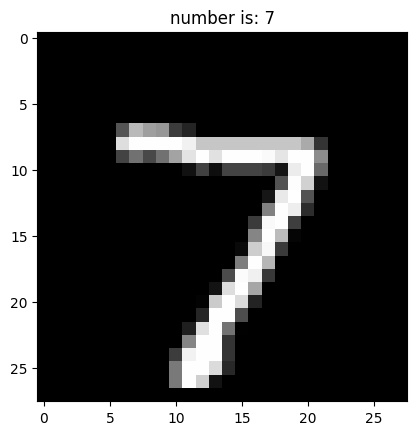

In [3]:
# Let us visualize the first training sample using the Matplotlib library with the imshow function
from matplotlib import pyplot as plt
plt.title(f"number is: {test_labels[0]}")
plt.imshow(test_images[0], cmap="grey")
plt.show()

The database contains images of handwritten digits. Hence, they belong to one of 10 categories, depending on the digit they represent. 
Reminder: in order to do multi-class classification, we use the softmax function, which outputs a multinomial probability distribution. That means that the output to our model will be a vector of size $10$, containing probabilities (meaning that the elements of the vector will be positive sum to $1$).
For easy computation, we want to true labels to be represented with the same format: that is what we call **one-hot encoding**. For example, if an image $\mathbf{x}$ represents the digit $5$, we have the corresponding one_hot label (careful, $0$ will be the first digit): 
$$ \mathbf{y} = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0] $$
Here, you need to turn train and test labels to one-hot encoding using the following function: 

<div class='alert alert-block alert-info'>
            Code:</div>

In [4]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print(f"The trained labels after categorical are: {train_labels}")
print(f"The test labels after categorical are: {test_labels}")


The trained labels after categorical are: [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
The test labels after categorical are: [[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Images are black and white, with size $28 \times 28$. We will work with them using a simple linear classification model, meaning that we will have them as vectors of size $(784)$.
You should then transform the images to the size $(784)$ using the numpy function ```reshape```.

Then, after casting the pixels to floats, normalize the images so that they have zero-mean and unitary deviation. Be careful to your methodology: while you have access to training data, you may not have access to testing data, and must avoid using any statistic on the testing dataset.

<div class='alert alert-block alert-info'>
            Code:</div>

In [5]:
# Reshape images to vectors of pixels
img_rows, img_cols = train_images.shape[1], train_images.shape[2]
train_images = train_images.reshape((train_images.shape[0], img_rows * img_cols))
test_images = test_images.reshape((test_images.shape[0], img_rows * img_cols))


# Cast pixels from uint8 to float32
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Now let us normalize the images so that they have zero mean and standard deviation
# Hint: are real testing data statistics known at training time ?

var = np.var(train_images)
mean = np.mean(train_images)

train_images = (train_images - mean) / np.sqrt(var)
test_images = (test_images - mean) / np.sqrt(var)


# First part: working with Numpy

Look at this [cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf) for some basic information on how to use numpy.

### Defining the model 

We will here create a simple, linear classification model. We will take each pixel in the image as an input feature (making the size of the input to be $784$) and transform these features with a weight matrix $\mathbf{W}$ and a bias vector $\mathbf{b}$. Since there is $10$ possible classes, we want to obtain $10$ scores. Then, 
$$ \mathbf{W} \in \mathbb{R}^{784 \times 10} $$
$$ \mathbf{b} \in \mathbb{R}^{10} $$

and our scores are obtained with:
$$ \mathbf{z} = \mathbf{W}^{T} \mathbf{x} +  \mathbf{b} $$

where $\mathbf{x} \in \mathbb{R}^{784}$ is the input vector representing an image.
We note $\mathbf{y} \in \mathbb{R}^{10}$ as the target one_hot vector. 

Here, you fist need to initialize $\mathbf{W}$ and $\mathbf{b}$ using ```np.random.normal``` and ```np.zeros```, then compute $\mathbf{z}$.
<div class='alert alert-block alert-info'>
            Code:</div>

In [6]:
# To avoid implementing a complicated gradient back-propagation,
# we will try a very simple architecture with one layer 
def initLayer(n_input,n_output):
    """
    Initialize the weights, return the number of parameters
    Inputs: n_input: the number of input units - int
          : n_output: the number of output units - int
    Outputs: W: a matrix of weights for the layer - numpy ndarray
           : b: a vector bias for the layer - numpy ndarray
           : nb_params: the number of parameters  - int
    """

    
    # Create W at the right size with a normal distribution
    W = np.random.normal(0, 1, size=(n_input, n_output))
    # Create b at the right size, with zeros
    b = np.random.normal(0, 1, n_output)
    nb_params = np.size(W) + np.size(b)
    return W, b, nb_params

In [7]:
n_training = train_images.shape[0] 
n_feature = train_images.shape[1]
n_labels = 10
W, b, nb_params = initLayer(n_feature, n_labels)

<div class='alert alert-block alert-info'>
            Code:</div>

In [8]:
def forward(W, b, X):
    """
    Perform the forward propagation
    Inputs: W: the weights - numpy ndarray
          : b: the bias - numpy ndarray
          : X: the batch - numpy ndarray
    Outputs: z: outputs - numpy ndarray
    """
    z = np.dot(X, W) + b
    return z

### Computing the output 

To obtain classification probabilities, we use the softmax function:
$$ \mathbf{o} = softmax(\mathbf{z}) \text{         with          } o_i = \frac{\exp(z_i)}{\sum_{j=0}^{9} \exp(z_j)} $$

The usual difficulty with the softmax function is the possibility of overflow when the scores $z_i$ are already large. Since a softmax is not affected by a shift affecting the whole vector $\mathbf{z}$:
$$ \frac{\exp(z_i - c)}{\sum_{j=0}^{9} \exp(z_j - c)} =  \frac{\exp(c) \exp(z_i)}{\exp(c) \sum_{j=0}^{9} \exp(z_j)} = \frac{\exp(z_i)}{\sum_{j=0}^{9} \exp(z_j)}$$
what trick can we use to ensure we will not encounter any overflow ? 
<div class='alert alert-block alert-info'>
            Code:</div>

In [9]:
def softmax(z):
    """
    Perform the softmax transformation to the pre-activation values
    Inputs: z: the pre-activation values - numpy ndarray
    Outputs: out: the activation values - numpy ndarray
    """

    # Let us take the max value in order not to overflow
    max_value = np.max(z)
    out = np.exp(z - max_value)/ np.sum(np.exp(z - max_value))
    return out

### Making updates

We define a learning rate $\eta$. The goal is to be able to apply updates:
$$ \mathbf{W}^{t+1} = \mathbf{W}^{t} + \nabla_{\mathbf{W}} l_{MLE} $$

In order to do this, we will compute this gradient (and the bias) in the function ```update```. In the next function ```updateParams```, we will actually apply the update with regularization. 

Reminder: the gradient $\nabla_{\mathbf{W}} l_{MLE}$ is the matrix containing the partial derivatives 
$$ \left[\frac{\delta l_{MLE}}{\delta W_{ij}}\right]_{i=1..784, j=1..10} $$
**Remark**: Careful, the usual way of implementing this in python has the dimensions of $\mathbf{W}$ reversed compared to the notation of the slides.

Coordinate by coordinate, we obtain the following update: 
$$ W_{ij}^{t+1} = W_{ij}^{t} + \eta \frac{\delta l_{MLE}}{\delta W_{ij}} $$

Via the chain rule, we obtain, for an input feature $i \in [0, 783]$ and a output class $j \in [0, 9]$: $$\frac{\delta l_{MLE}}{\delta W_{ij}} = \frac{\delta l_{MLE}}{\delta z_{j}} \frac{\delta z_j}{\delta W_{ij}}$$ 

It's easy to compute that $\frac{\delta z_j}{\delta W_{ij}} = x_i$

We compute the softmax derivative, to obtain:
$$ \nabla_{\mathbf{z}} l_{MLE} = \mathbf{o} - \mathbf{y} $$

Hence, $\frac{\delta l_{MLE}}{\delta z_{j}} = o_j - y_j$ and we obtain that $$\frac{\delta l_{MLE}}{\delta W_{ij}} = (o_j - y_j) x_i$$

This can easily be written as a scalar product, and a similar computation (even easier, actually) can be done for $\mathbf{b}$. Noting $\nabla_{\mathbf{z}} l_{MLE} = \mathbf{o} - \mathbf{y}$ as ```grad``` in the following function, compute the gradients $\nabla_{\mathbf{W}} l_{MLE}$ and $\nabla_{\mathbf{b}} l_{MLE}$ in order to call the function ```updateParams```.

Note: the regularizer and the weight_decay $\lambda$ are used in ```updateParams```.

<div class='alert alert-block alert-info'>
            Code:</div>

The update rule is affected by regularization. We implement two cases: No regularization, or L2 regularization. Use the two possible update rules to implement the following function: <div class='alert alert-block alert-info'>
            Code:</div>

In [10]:
def updateParams(param, grad_param, eta, regularizer=None, weight_decay=0.):
    """
    Perform the update of the parameters
    Inputs: param: the network parameters - ndarray
          : grad_param: the updates of the parameters - ndarray
          : eta: the step-size of the gradient descent - float
          : weight_decay: the weight-decay - float
    Outputs: the parameters updated - ndarray
    """
    if regularizer==None:
        grad = param - eta * grad_param
        return grad
    elif regularizer=='L2':
        param = - eta * grad_param + (1 - 2*weight_decay)*param
        return param
    else:
        raise NotImplementedError

In [11]:
def update(eta, W, b, grad, X, regularizer, weight_decay):
    """
    Perform the update of the parameters
    Inputs: eta: the step-size of the gradient descent - float 
          : W: the weights - ndarray
          : b: the bias -  ndarray
          : grad: the gradient of the activations w.r.t. to the loss -  list of ndarray
          : X: the data -  ndarray
          : regularizer: 'L2' or None - the regularizer to be used in updateParams
          : weight_decay: the weight decay to be used in updateParams - float
    Outputs: W: the weights updated -  ndarray
           : b: the bias updated -  ndarray
    """
    X=X.reshape((img_rows*img_cols, 1))
    grad=grad.reshape(1, -1)
    grad_w = X @ grad
    grad_b = grad
        
    W = updateParams(W, grad_w, eta, regularizer, weight_decay)
    b = updateParams(b, grad_b, eta, regularizer, weight_decay)
    
    return W, b

### Computing the Accuracy

Here, we simply use the model to predict the class (by taking the argmax of the output !) for every example in ```X```, and count the number of times the model is right, to output the accuracy.
<div class='alert alert-block alert-info'>
            Code:</div>

In [12]:
def computeAcc(W, b, X, labels):
    """
    Compute the loss value of the current network on the full batch
    Inputs: act_func: the activation function - function
          : W: the weights - list of ndarray
          : B: the bias - list of ndarray
          : X: the batch - ndarray
          : labels: the labels corresponding to the batch
    Outputs: loss: the negative log-likelihood - float
           : accuracy: the ratio of examples that are well-classified - float
    """ 
    # Forward propagation
    z = forward(W, b, X)
 
    # Compute the softmax and the prediction
    out = softmax(z)
    pred = np.argmax(out, axis=1)
    
    # Compute the accuracy
    trueValue = np.argmax(labels, axis=1)
    accuracy = np.mean(trueValue == pred)
      
    return accuracy

### Preparing training

The following hyperparameters are given. Next, we can assemble all the function previously defined to implement a training loop. We will train the classifier on **one epoch**, meaning that the model will see each training example once. 

In [13]:
# Optimization
eta = 0.01
regularizer = 'L2'
weight_decay = 0.0001

# Training
log_interval = 5000

<div class='alert alert-block alert-info'>
            Code:</div>

In [14]:
# Data structures for plotting
g_train_acc=[]
g_valid_acc=[]

#######################
### Learning process ##
#######################
for j in range(n_training):
    # Getting the example
    X, y = train_images[j] , train_labels[j]

    # Forward propagation
    z = forward(W, b, X)

    # Compute the softmax
    out = softmax(z)
        
    # Compute the gradient at the top layer
    derror = out - y # This is o - y 

    # Update the parameters
    W, b = update(eta, W, b, derror, X, regularizer, weight_decay=weight_decay)

    if j % log_interval == 0:
        # Every log_interval examples, look at the training accuracy
        train_accuracy = computeAcc(W, b, train_images, train_labels) 

        # And the testing accuracy
        test_accuracy = computeAcc(W, b, test_images, test_labels) 
        

        g_train_acc.append(train_accuracy)
        g_valid_acc.append(test_accuracy)
        result_line = str(int(j)) + " " + str(train_accuracy) + " " + str(test_accuracy) + " " + str(eta)
        print(result_line)

g_train_acc.append(train_accuracy)
g_valid_acc.append(test_accuracy)
result_line = "Final result:" + " " + str(train_accuracy) + " " + str(test_accuracy) + " " + str(eta)
print(result_line)     

0 0.10355 0.0977 0.01
5000 0.8314166666666667 0.8394 0.01
10000 0.8184 0.8234 0.01
15000 0.8267166666666667 0.8258 0.01
20000 0.8489666666666666 0.8545 0.01
25000 0.8259 0.8356 0.01
30000 0.7985833333333333 0.8013 0.01
35000 0.7746666666666666 0.7725 0.01
40000 0.8246833333333333 0.8249 0.01
45000 0.8499833333333333 0.8532 0.01
50000 0.8327333333333333 0.8393 0.01
55000 0.8006333333333333 0.7995 0.01
Final result: 0.8006333333333333 0.7995 0.01


What can you say about the performance of this simple linear classifier ?
<div class='alert alert-block alert-warning'>
            Answer:</div>

This linear classifier performs well, but there is still some room for improvement. We can add more layers or do a PCA to get the most important components and train on them.

# Second part: Autoencoder with Keras

## Autoencoder and PCA

First, we will try to connect the representation produced by Principal Component Analysis with what is learnt by a simple, linear, autoencoder. We will use the ```scikit-learn``` implementation of the ```PCA``` to obtain the two first components (hint: use the attribute ```.components_```), and visualize them:
<div class='alert alert-block alert-info'>
            Code:</div>

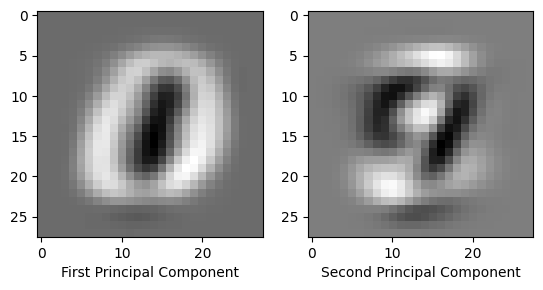

In [15]:
from sklearn.decomposition import PCA

# Let's find the first 2 PCA components
num_components = 2
pca = PCA(n_components=num_components).fit(train_images)

# Reshape so they resemble images and we can print them
eigen_mnist = pca.components_.reshape((num_components, img_rows, img_cols))

# Show the reshaped principal components
f, ax = plt.subplots(1,2)
ax[0].imshow(eigen_mnist[0], cmap='gray')
ax[0].set_xlabel('First Principal Component')
ax[1].imshow(eigen_mnist[1], cmap='gray')
ax[1].set_xlabel('Second Principal Component')
plt.show()

In [16]:
# Print the variance explained by those components
pca.explained_variance_

array([53.903347, 39.412014], dtype=float32)

Comment on the visualization in relation to the variance explained by only keeping the two principal components:
<div class='alert alert-block alert-warning'>
            Answer:</div>

We can observe that the first principal component is close to 0, while the second one does not. The variance thus affects how clear we can see the numbers, bigger variance => better visualisation. So intuitively, we can get the components of the biggest variance and train on them.

### Implementing the Autoencoder with Keras

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD

Now, we will use Keras to implement the autoencoder. You can take a look at this [cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Keras_Cheat_Sheet_Python.pdf) for some basic commands to use keras.

In this first case, we implement a **simple linear autoencoder**. Build it in order to have the same capacity as the PCA decomposition (2 hidden dimensions !) we made just above. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [18]:
# Input layer
input_layer = Input(shape=(img_rows * img_cols,), name="input_layer")

# Encoding layer
latent_view = Dense(num_components, name="latent_layer")(input_layer)

# Decoding layer
output_layer = Dense(img_rows * img_cols, name="output_layer", activation='sigmoid')(latent_view)

ae_model = Model(input_layer, output_layer, name='ae_model')
ae_model.summary()

I0000 00:00:1743585062.042277   57377 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "ae_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_layer (Dense)            │ (None, 2)              │         1,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 784)            │         2,352 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,922 (15.32 KB)

 Trainable params: 3,922 (15.32 KB)

 Non-trainable params: 0 (0.00 B)

What loss shoud we use ? Choose the usual one and import it directly from Keras. You can use a simple ```SGD``` optimizer, and then compile the model; finally, train it to rebuild images from the original examples. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [19]:
from tensorflow.keras.losses import MeanSquaredError
loss = MeanSquaredError()

optimizer = SGD(learning_rate=1e-1) 
ae_model.compile(optimizer=optimizer, loss=loss) 

batch_size = 128
epochs = 10
# No noise here - we want to train a simple auto-encoder and compare visually with PCA
history = ae_model.fit(train_images,
                       train_images,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(test_images, test_images))

Epoch 1/10


I0000 00:00:1743585063.501271   57505 service.cc:148] XLA service 0x7fc6b0004360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743585063.501825   57505 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-04-02 11:11:03.523902: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743585063.566868   57505 cuda_dnn.cc:529] Loaded cuDNN version 90300


 56/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2475

I0000 00:00:1743585065.343647   57505 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.1398 - val_loss: 0.8132
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8060 - val_loss: 0.8041
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8011 - val_loss: 0.8015
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7970 - val_loss: 0.7975
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7930 - val_loss: 0.7881
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7824 - val_loss: 0.7772
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7724 - val_loss: 0.7699
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7667 - val_loss: 0.7652
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7618 - val_loss: 0.7621
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7582 - val_loss: 0.7595


Assuming that the name of your layer (obtained through the command ```model.summary()```) is ```'layer'```, here is the way to obtained the weights. Visualize the weights of the encoder and compare them to the two components obtained through the PCA.

In [20]:
weights, bias = ae_model.get_layer('latent_layer').get_weights()

<div class='alert alert-block alert-info'>
            Code:</div>

Text(0.5, 0, 'Second Principal Component')

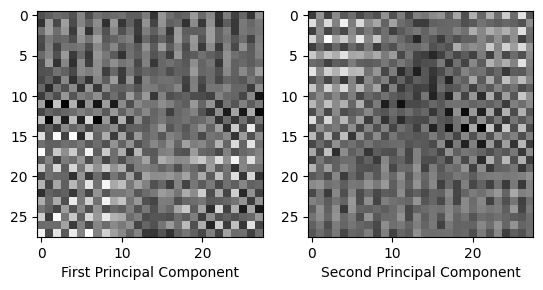

In [21]:
# Show the two dimensions of the encoder, in a similar manner to the principal components
# (after reshaping them as images !)
eigen_W = weights.reshape((num_components, img_rows, img_cols))

# Show the reshaped principal components
f, ax = plt.subplots(1,2)
ax[0].imshow(eigen_W[0], cmap='gray')
ax[0].set_xlabel('First Principal Component')
ax[1].imshow(eigen_W[1], cmap='gray')
ax[1].set_xlabel('Second Principal Component')

Now, visualize the images rebuilt by the network !
<div class='alert alert-block alert-info'>
            Code:</div>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


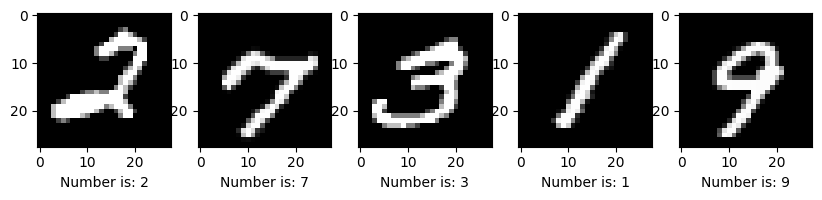

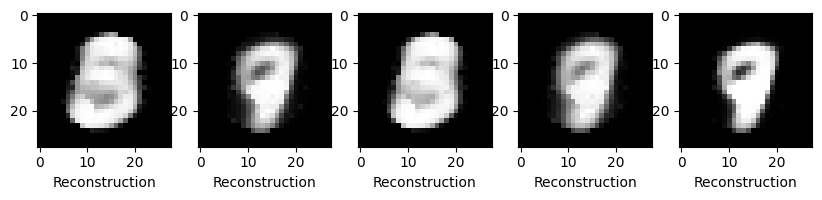

In [22]:
# Select a few images at random: look from n
n = np.random.randint(0,len(test_images)-5)

# Plot a few images from n  
f, ax = plt.subplots(1,5, figsize=(10, 10))
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(test_images[a].reshape((img_rows, img_cols)), cmap="grey")
    ax[i].set_xlabel(f"Number is: {np.argmax(test_labels[a])}")
# Get the prediction from the model 


# ... and plot them 
f, ax = plt.subplots(1,5, figsize=(10, 10))
prediction = ae_model.predict(test_images[n:n+5])
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(prediction[a-n].reshape((img_rows, img_cols)), cmap = "grey")
    ax[i].set_xlabel(f"Reconstruction")

Do the same ( = build a new model) with a latent dimension that is largely higher than 2. Compare the visualizations and the images that are rebuilt. 
<div class='alert alert-block alert-info'>
            Code:</div>

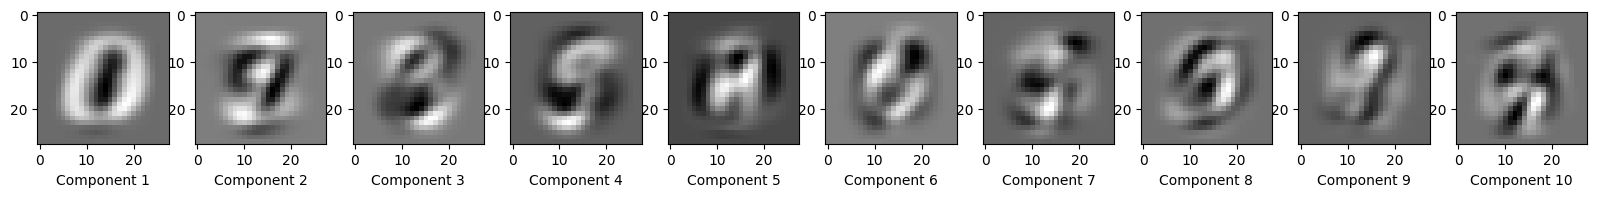

In [23]:
from sklearn.decomposition import PCA

# Let's find the first 2 PCA components
num_components = 100
pca = PCA(n_components=num_components).fit(train_images)

# Reshape so they resemble images and we can print them
eigen_mnist = pca.components_.reshape((num_components, img_rows, img_cols))

# Show the reshaped principal components
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 10)

for i in range(10):
    ax[i].imshow(eigen_mnist[i], cmap='gray')
    ax[i].set_xlabel(f'Component {i+1}')
plt.show()

In [24]:
# Input layer
input_layer = Input(shape=(img_rows * img_cols,), name="input_layer")

# Encoding layer
latent_view = Dense(num_components, name="latent_layer")(input_layer)

# Decoding layer
output_layer = Dense(img_rows * img_cols, name="output_layer", activation='sigmoid')(latent_view)

ae_model = Model(input_layer, output_layer, name='ae_model')
ae_model.summary()

Model: "ae_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_layer (Dense)            │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 784)            │        79,184 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,684 (615.95 KB)

 Trainable params: 157,684 (615.95 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
loss = MeanSquaredError()

optimizer = SGD(learning_rate=1e-1) 
ae_model.compile(optimizer=optimizer, loss=loss) 

batch_size = 128
epochs = 10
# No noise here - we want to train a simple auto-encoder and compare visually with PCA
history = ae_model.fit(train_images,
                       train_images,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(test_images, test_images))

Epoch 1/10


2025-04-02 11:11:23.682617: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19', 16 bytes spill stores, 16 bytes spill loads

2025-04-02 11:11:24.235450: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19', 52 bytes spill stores, 52 bytes spill loads

2025-04-02 11:11:24.270214: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_190', 44 bytes spill stores, 44 bytes spill loads

2025-04-02 11:11:24.402745: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19', 52 bytes spill stores, 52 bytes spill loads

2025-04-02 11:11:24.571153: I external/local_xla/xla/stream_executo

451/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0474

2025-04-02 11:11:26.817546: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19', 52 bytes spill stores, 52 bytes spill loads

2025-04-02 11:11:26.887111: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19', 16 bytes spill stores, 16 bytes spill loads

2025-04-02 11:11:27.294573: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19', 60 bytes spill stores, 60 bytes spill loads

2025-04-02 11:11:27.304251: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_190', 52 bytes spill stores, 52 bytes spill loads

2025-04-02 11:11:27.621226: I external/local_xla/xla/stream_executo

469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 1.0415 - val_loss: 0.7795
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7623 - val_loss: 0.7257
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7123 - val_loss: 0.6877
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6784 - val_loss: 0.6627
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6566 - val_loss: 0.6454
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6394 - val_loss: 0.6322
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6270 - val_loss: 0.6217
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6162 - val_loss: 0.6127
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6073 - val_loss: 0.6051
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6001 - val_loss: 0.5984


In [26]:
weights, bias = ae_model.get_layer('latent_layer').get_weights()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
(5, 784)


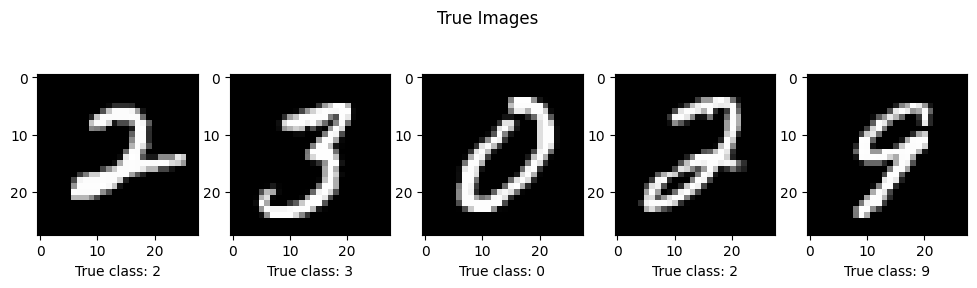

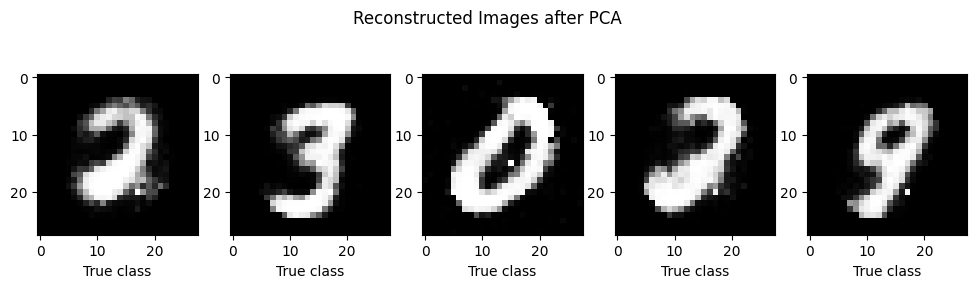

In [27]:
# Select a few images at random: look from n
n = np.random.randint(0,len(test_images)-5)

# Plot a few images from n  
f, ax = plt.subplots(1,5, figsize=(12, 3))
f.suptitle('True Images')
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(test_images[a].reshape((img_rows,img_cols)), cmap='gray')
    ax[i].set_xlabel('True class: ' + str(np.argmax(test_labels[a])))
    
# Get the prediction from the model 
prediction = ae_model.predict(test_images[n:n+5])
print(prediction.shape)

# ... and plot them 
f, ax = plt.subplots(1,5, figsize=(12, 3))
f.suptitle('Reconstructed Images after PCA')
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(prediction[a-n].reshape((img_rows,img_cols)), cmap='gray')
    ax[i].set_xlabel('True class')

### De-noising Autoencoder

Now, we can implement a **de-noising autoencoder**. The following function will transform an array of images by adding it random noise. Create a new autoencoder model, this time with **more layers** and **non-linear activations** (like the ReLU) and train it to rebuild the de-noised images. Display some testing images, with noise, and re-built.

In [28]:
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )
    return noisy_array

In [29]:
# Create a copy of the data with added noise
noisy_train_images = noise(train_images)
noisy_test_images = noise(test_images)

<div class='alert alert-block alert-info'>
            Code:</div>

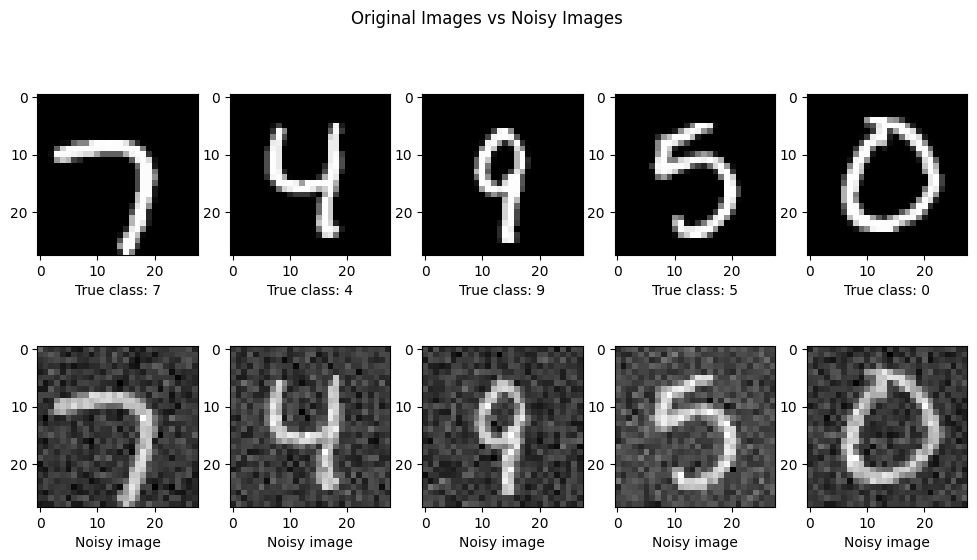

Model: "denoising_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode3 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoded4 (Dense)                │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 460,240 (1.76 MB)

 Trainable params: 460,240 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2025-04-02 11:11:49.732729: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_197', 360 bytes spill stores, 360 bytes spill loads

2025-04-02 11:11:50.443450: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_204', 24 bytes spill stores, 24 bytes spill loads



452/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7450

2025-04-02 11:11:55.754159: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_197', 160 bytes spill stores, 160 bytes spill loads

2025-04-02 11:11:55.933088: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_190_0', 4 bytes spill stores, 4 bytes spill loads

2025-04-02 11:11:56.282375: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_204', 96 bytes spill stores, 120 bytes spill loads

2025-04-02 11:11:56.399056: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_211_0', 68 bytes spill stores, 68 bytes spill loads



469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 0.7422 - val_loss: 0.6089
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5918 - val_loss: 0.5689
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5616 - val_loss: 0.5582
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5514 - val_loss: 0.5519
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5458 - val_loss: 0.5470
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5422 - val_loss: 0.5458
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5392 - val_loss: 0.5427
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5378 - val_loss: 0.5399
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5343 - val_loss: 0.5392
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5343 - val_loss: 0.5385


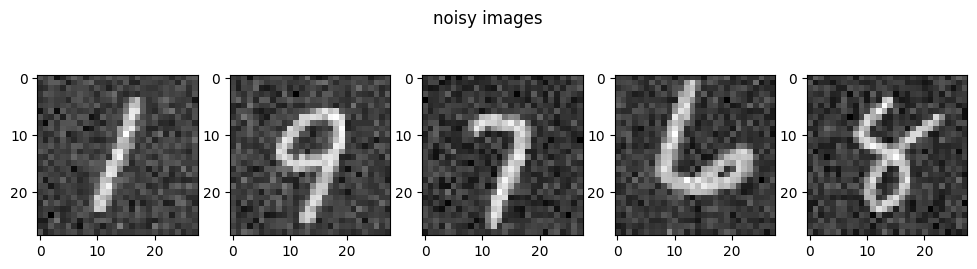

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


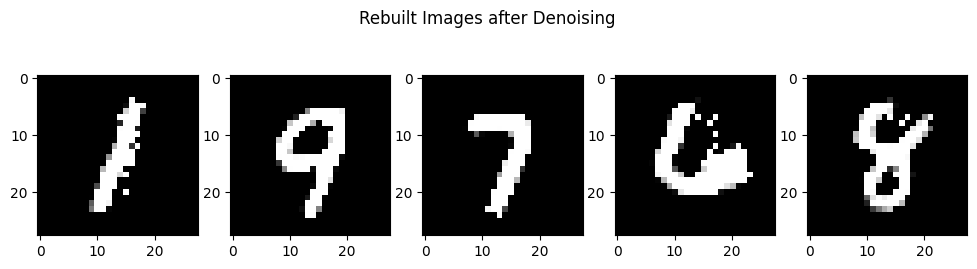

dict_keys(['loss', 'val_loss'])


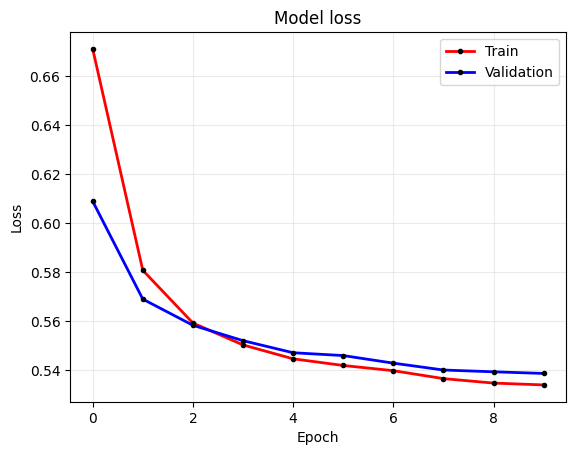

In [ ]:
# Visualize some of the images with noise against the originals
n = np.random.randint(0,len(test_images)-5)
f, ax = plt.subplots(2,5, figsize=(12, 6))
f.suptitle('Original Images vs Noisy Images')

for i,a in enumerate(range(n,n+5)):
    ax[0,i].imshow(test_images[a].reshape((img_rows,img_cols)), cmap='gray')
    ax[0,i].set_xlabel('True class: ' + str(np.argmax(test_labels[a])))
    ax[1,i].imshow(noisy_test_images[a].reshape((img_rows,img_cols)), cmap='gray')
    ax[1,i].set_xlabel('Noisy image')
plt.show()

# Build a new model with more layers and Relu activations
input_layer = Input(shape=(img_rows*img_cols,), name='input_layer')

# Let us put more Relus here
encode = Dense(256, activation='relu', name='encode1')(input_layer)
encod = Dense(128, activation='relu', name='encode2')(encode)
encod = Dense(64, activation='relu', name='encode3')(encod)
encod = Dense(32, activation='relu', name='encode4')(encod)

decode = Dense(64, activation='relu', name='decode1')(encode)
decode = Dense(128, activation='relu', name='decode2')(decode)
decode = Dense(256, activation='relu', name='decode3')(decode)
decode = Dense(img_rows*img_cols, activation='sigmoid', name='decoded4')(decode)


denoising_model = Model(input_layer, decode, name='denoising_model')
denoising_model.summary()

# Compile it but here, use noised data as inputs !
loss = MeanSquaredError()
optimizer = SGD(learning_rate=1e-1) 
denoising_model.compile(optimizer='adam', loss=loss)

history = denoising_model.fit(noisy_train_images, 
                        train_images,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1,
                        shuffle=True,
                        validation_data=(noisy_test_images, test_images))

# Visualize the images rebuilt by the model !

n = np.random.randint(0,len(test_images)-5)

f, ax = plt.subplots(1,5, figsize=(12, 3))
f.suptitle('noisy images')
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(noisy_test_images[a].reshape((img_rows,img_cols)), cmap='gray')
plt.show()


f, ax = plt.subplots(1,5, figsize=(12, 3))
f.suptitle('Rebuilt Images after Denoising')
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(denoising_model.predict(noisy_test_images[n:n+5])[i].reshape((img_rows,img_cols)), cmap='gray')
plt.show()

#plotting the training and validation loss
print(history.history.keys())
plt.plot(history.history['loss'], label='train', color='red', linestyle='-', linewidth=2, marker='o', markersize=3, markerfacecolor='black', markeredgecolor='black')
plt.plot(history.history['val_loss'], color='blue', linestyle='-', linewidth=2, marker='o', markersize=3, markerfacecolor='black', markeredgecolor='black')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(alpha=0.25)
plt.show()

Assuming that we normalize the images to be in the 0-1 range, what other loss function could we use ?
<div class='alert alert-block alert-warning'>
            Answer:</div>

If we normalize the images to 0-1, we could use either Cross-Entropy or Hinge loss function as loss functions. Since the images are normalized, they can be considered as a Probaibility distribution. This explains the choice of the loss functions.